In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from transformers import AutoTokenizer, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve

/Users/bachirzerroug/Library/Caches/pypoetry/virtualenvs/transformers-implementation-xd7zxmCX-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/Users/bachirzerroug/Documents/transformers-implementation')

In [3]:
from src.local_transformers import Encoder
from src.utils import EarlyStopping, CustomDataset, PreTrainedTokenizer

In [4]:
# Import data
emails_raw = pd.read_csv('src/data/spam.csv')

In [5]:
emails_raw

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
# Look at some examples
print(emails_raw['Message'].iloc[12])
print(emails_raw['Message'].iloc[0])
print(emails_raw['Message'].iloc[55])
print(emails_raw['Message'].iloc[700])

URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Do you know what Mallika Sherawat did yesterday? Find out now @  &lt;URL&gt;
K..u also dont msg or reply to his msg..


In [7]:
# Get some basic stats
print(f'shape of the dataset: {emails_raw.shape}')

# Number of classes
nb_classes = emails_raw['Category'].nunique()
print(f'Number unique classes {nb_classes}')

# Proportion of classes
proportions_classes = emails_raw.groupby('Category').count()/len(emails_raw)
print(f'Proportions of classes: \n {proportions_classes}')
# Number of distinct emails
print(f'Number of distinct emails: {emails_raw.Message.nunique()}')


shape of the dataset: (5572, 2)
Number unique classes 2
Proportions of classes: 
            Message
Category          
ham       0.865937
spam      0.134063
Number of distinct emails: 5157


In [8]:
message_count = emails_raw.groupby('Message').count()
message_count.columns = ['nb_messages']
message_count = message_count[message_count['nb_messages']>1]

In [9]:
message_count.sort_values(by='nb_messages')

,nb_messages
Message,
"Mila, age23, blonde, new in UK. I look sex with UK guys. if u like fun with me. Text MTALK to 69866.18 . 30pp/txt 1st 5free. £1.50 increments. Help08718728876",2
Ok lor.,2
Ok thanx...,2
Ok then i will come to ur home after half an hour,2
PRIVATE! Your 2004 Account Statement for 07742676969 shows 786 unredeemed Bonus Points. To claim call 08719180248 Identifier Code: 45239 Expires,2
...,...
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st ""Ur Lovely Friendship""... good morning dear",4
Ok...,10


We see that repeated emails are
1. emails with basic answers like 'OK'
2. emails we can send automatically when someone call us "Sorry, I'll call later"
3. emails considered as chain "Send this to Ten special people"
4. spams received by multiple accounts  
...  

Let's check if they belong to the same class at least

In [10]:
def check_all_msg_same_class(message):
    list_similar_emails = emails_raw[emails_raw['Message'] == message]['Category']
    class_email = list_similar_emails.iloc[0]
    return list_similar_emails.tolist() == [class_email]*len(list_similar_emails)

In [11]:
for message in message_count.index:
    if not check_all_msg_same_class(message):
        print('There are similar emails that have at least 2 different classes')

Distinct messages have the same class in the dataset.  
Which means that there is not incoherence in the dataset information carried by these emails.  
The decision concerning these emails depend on how the dataset is built.
1. If the dataset is a sample of real emails received by a representative group of persons, then we can keep them. Indeed by keeping them we give them more weight which is logical as they appear multiple times.
2. If these emails are selected, it doesn't make sense to give more weight to specific emails, except if there is a idea behind.  

As we don't have information, we suppose that these emails are a sample of real emails

# Transform dataframe to a pytorch Dataclass

## First transform the category into a binary category with 0 and 1

In [12]:
emails_raw['category_binary'] = [0 if msg == 'ham' else 1 for msg in emails_raw['Category']]
emails_raw['category_binary']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: category_binary, Length: 5572, dtype: int64

## Train Val Test Split

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(emails_raw['Message'], 
                                                            torch.tensor(emails_raw['category_binary'], dtype=float), 
                                                            test_size=0.2, 
                                                            shuffle=True,
                                                            stratify=torch.tensor(emails_raw['category_binary'], 
                                                                     dtype=torch.float32),
                                                            random_state=12)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.2, 
                                                  shuffle=True,
                                                  stratify=y_train_val,
                                                  random_state=24)

## Tokenize messages

In [18]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [19]:
X_train

3378    Yup. Wun believe wat? U really neva c e msg i ...
3743    Hey i'm bored... So i'm thinking of u... So wa...
2116    Well I wasn't available as I washob nobbing wi...
569     Love it! Daddy will make you scream with pleas...
1988                     No calls..messages..missed calls
                              ...                        
992     Hi im having the most relaxing time ever! we h...
2848    Free-message: Jamster!Get the crazy frog sound...
999     Then ü wait 4 me at bus stop aft ur lect lar. ...
3376                                                   :)
3194    I will lick up every drop :) are you ready to ...
Name: Message, Length: 3565, dtype: object

In [20]:
#max_length = max([len(message) for message in X_train])
#tokenizer = PreTrainedTokenizer(tokenizer_type="autotokenizer_best_best_cased",
#                                max_length=max_length,
#                                truncation=True,
#                                padding="max_length"
#                                )

X_train_tokenized = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors="pt").input_ids
X_val_tokenized = tokenizer(X_val.tolist(), truncation=True, padding=True, return_tensors="pt").input_ids
X_test_tokenized = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors="pt").input_ids

#y_train = torch.tensor(y_train.to_numpy(), dtype=float)
#y_val = torch.tensor(y_val.to_numpy(), dtype=float)
#y_test = torch.tensor(y_test.to_numpy(), dtype=float)

vocab_size = tokenizer.vocab_size

In [21]:
dataset_train = CustomDataset(X_train_tokenized, y_train)
dataset_val = CustomDataset(X_val_tokenized, y_val)
dataset_test = CustomDataset(X_test_tokenized, y_test)

## Create dataset

In [22]:
#tokenizer_input = AutoTokenizer.from_pretrained("bert-base-cased")

#encoded_input = tokenizer_input(emails_raw['Message'].tolist(), padding=True, return_tensors="pt")

#x_train_val, x_test, y_train_val, y_test = train_test_split(encoded_input.input_ids, 
#                                                            torch.tensor(emails_raw['category_binary'], 
#                                                                         dtype=torch.float32), 
#                                                            train_size=0.8, 
#                                                            shuffle=True,
#                                                            stratify=torch.tensor(emails_raw['category_binary'], 
#                                                                     dtype=torch.float32),
#                                                            random_state=12)

#x_train, x_val, y_train, y_val = train_test_split(x_train_val,
#                                                  y_train_val,
#                                                  train_size=0.8, 
#                                                  shuffle=True,
#                                                  stratify=y_train_val,
#                                                  random_state=56)
    
#vocab_size = tokenizer_input.vocab_size

## Create model

In [26]:
class SpamClassifier(nn.Module):
    def __init__(self,
                 embedding_dim,
                 latent_dim,
                 vocab_size, 
                 num_heads, 
                 num_layers, 
                 factor):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.factor = factor

        self.encoder = Encoder(vocab_size=self.vocab_size, 
                          embedding_dim=self.embedding_dim, 
                          num_heads=self.num_heads, 
                          num_layers=self.num_layers, 
                          factor=self.factor)

        self.linear = nn.Sequential(
            nn.Linear(self.embedding_dim, self.latent_dim),
            nn.ReLU(),
            nn.Linear(self.latent_dim, 1),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoded = self.encoder(x)
        mean_encoded = torch.mean(encoded, dim=1)
        linear = self.linear(mean_encoded)
        return self.sigmoid(linear)



In [27]:
# Instanciate basic paramters
learning_rate = 0.001
model = SpamClassifier(embedding_dim=256,
                       latent_dim=64,
                       vocab_size=vocab_size, 
                       num_heads=4, 
                       num_layers=3, 
                       factor=2
                    )

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nb_epochs = 15
batch_size = 64

In [28]:
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [29]:
def train(dataloader, model, loss_fn, optimizer):    
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        #pred = torch.tensor([elem[0] for elem in pred], requires_grad=True)
        loss = loss_fn(pred, y.float().unsqueeze(1))

        # Backpropagation
        # Backpropagate the prediction loss with a call to loss.backward(). 
        # PyTorch deposits the gradients of the loss w.r.t. each parameter.
        loss.backward()
        # Once we have our gradients, we call optimizer.step() to adjust the parameters 
        # by the gradients collected in the backward pass.
        optimizer.step()
        # Call optimizer.zero_grad() to reset the gradients of model parameters. 
        # Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [30]:
def eval(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, pr_aucs = 0, []
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            # Compute the the prediction error (loss) and convert it to numpy
            test_loss += loss_fn(pred, y.float().unsqueeze(1)).item()
            # Sum of correct predictions
            pr_aucs.append(average_precision_score(y.numpy(), pred.numpy()))
            y_true += y.numpy().tolist()
            y_pred += pred.numpy().tolist()
            
    test_loss /= num_batches
    pr_auc = np.mean(pr_aucs)
    print(f"Test Error: Avg loss: {test_loss:>8f} and pr auc: {pr_auc} \n")
    return test_loss, y_true, y_pred

In [31]:
#device = (
#    "cuda"
#    if torch.cuda.is_available()
#    else "mps"
#    if torch.backends.mps.is_available()
#    else "cpu"
#)

In [32]:
epochs = 15
early_stopping = EarlyStopping(patience=3, verbose=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val_loss, _, _ = eval(val_loader, model, loss_fn)
    
    # Check for early stopping
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Done!")

Epoch 1
-------------------------------
loss: 0.675759  [   64/ 3565]
loss: 0.337517  [  704/ 3565]
loss: 0.435348  [ 1344/ 3565]
loss: 0.460968  [ 1984/ 3565]
loss: 0.371320  [ 2624/ 3565]
loss: 0.397296  [ 3264/ 3565]
Test Error: Avg loss: 0.283714 and pr auc: 0.535563397740192 

EarlyStopping Counter: 0 out of 3
Epoch 2
-------------------------------
loss: 0.163386  [   64/ 3565]
loss: 0.270978  [  704/ 3565]
loss: 0.275881  [ 1344/ 3565]
loss: 0.261082  [ 1984/ 3565]
loss: 0.300599  [ 2624/ 3565]
loss: 0.322180  [ 3264/ 3565]
Test Error: Avg loss: 0.244212 and pr auc: 0.4900301331436712 

EarlyStopping Counter: 0 out of 3
Epoch 3
-------------------------------
loss: 0.109767  [   64/ 3565]
loss: 0.245081  [  704/ 3565]
loss: 0.267253  [ 1344/ 3565]
loss: 0.255206  [ 1984/ 3565]
loss: 0.284781  [ 2624/ 3565]
loss: 0.277842  [ 3264/ 3565]
Test Error: Avg loss: 0.278525 and pr auc: 0.47253661973895467 

EarlyStopping Counter: 1 out of 3
Epoch 4
-------------------------------
loss: 

In [281]:
epochs = 15
early_stopping = EarlyStopping(patience=3, verbose=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val_loss, _, _ = eval(val_loader, model, loss_fn)
    
    # Check for early stopping
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Done!")

Epoch 1
-------------------------------
loss: 0.672037  [   64/ 3565]
loss: 0.657527  [  704/ 3565]
loss: 0.649479  [ 1344/ 3565]
loss: 0.642694  [ 1984/ 3565]
loss: 0.622694  [ 2624/ 3565]
loss: 0.626600  [ 3264/ 3565]
Test Error: Avg loss: 0.568660 and pr auc: 0.48754765139183565 

EarlyStopping Counter: 0 out of 3
Epoch 2
-------------------------------
loss: 0.576001  [   64/ 3565]
loss: 0.579938  [  704/ 3565]
loss: 0.589280  [ 1344/ 3565]
loss: 0.592276  [ 1984/ 3565]
loss: 0.566333  [ 2624/ 3565]
loss: 0.585260  [ 3264/ 3565]
Test Error: Avg loss: 0.495582 and pr auc: 0.52185731287319 

EarlyStopping Counter: 0 out of 3
Epoch 3
-------------------------------
loss: 0.502517  [   64/ 3565]
loss: 0.520765  [  704/ 3565]
loss: 0.543668  [ 1344/ 3565]
loss: 0.554541  [ 1984/ 3565]
loss: 0.521868  [ 2624/ 3565]
loss: 0.553464  [ 3264/ 3565]
Test Error: Avg loss: 0.446019 and pr auc: 0.5226220862329568 

EarlyStopping Counter: 0 out of 3
Epoch 4
-------------------------------
loss: 0

In [33]:
test_loss, y_true, y_pred = eval(test_loader, model, loss_fn)

Test Error: Avg loss: 0.095430 and pr auc: 0.9794781228110675 



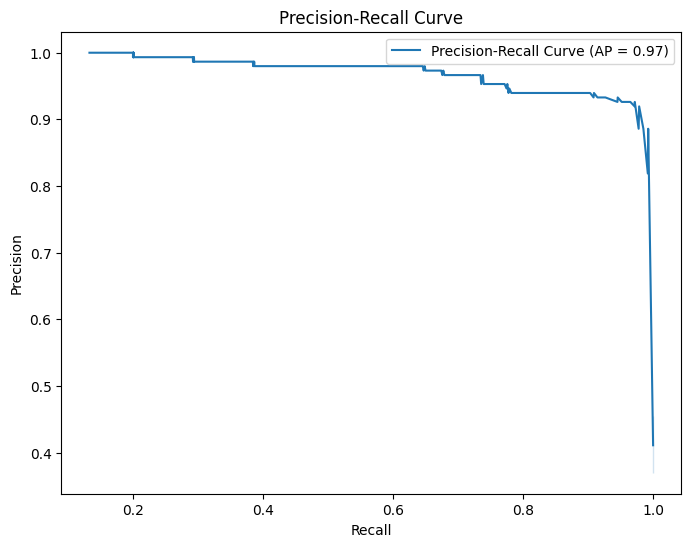

In [34]:
# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(x=precision, y=recall, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [35]:
y_true_pred = pd.DataFrame({'y_true': y_true, 'y_pred': [x[0] for x in y_pred]})

In [36]:
X

NameError: name 'X' is not defined

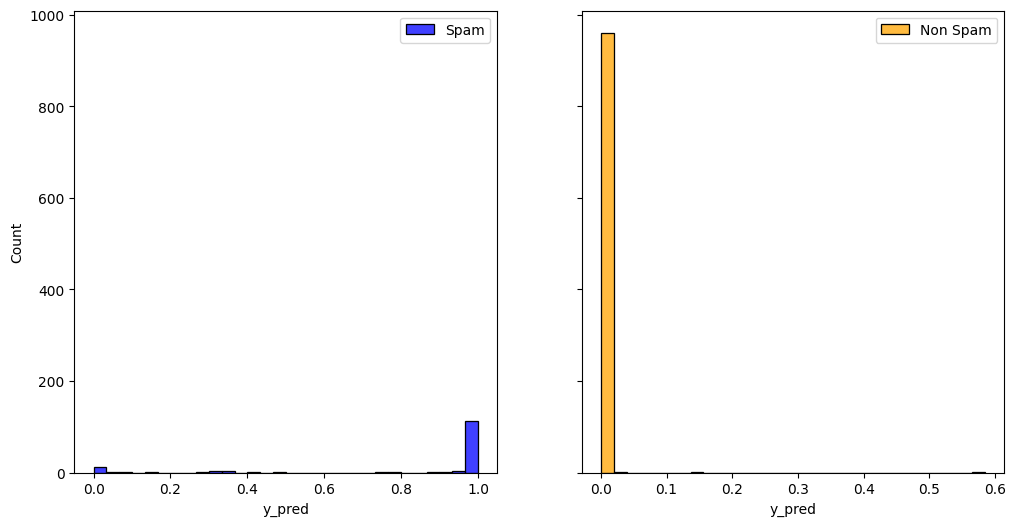

In [37]:
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the histograms side by side using Seaborn
sns.histplot(y_true_pred[y_true_pred['y_true'] == 1]['y_pred'], bins=30, ax=axes[0], color='blue', label='Spam')
sns.histplot(y_true_pred[y_true_pred['y_true'] == 0]['y_pred'], bins=30, ax=axes[1], color='orange', label='Non Spam')

# Add legend
axes[0].legend()
axes[1].legend()

# Show the plot
plt.show()